<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Testing_Pytrodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install PyWavelets

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ------- -------------------------------- 0.8/4.2 MB 16.8 MB/s eta 0:00:01
   ---------------------------- ----------- 3.0/4.2 MB 27.8 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 30.2 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 30.2 MB/s eta 0:00:01
   ----

In [3]:
import scipy as sci
import os
from matplotlib import pyplot as plt
import numpy as np

In [4]:
zl_dir = "C:\\Users\\dennis.tabuena\\Desktop\\ZL04_46_ch17_ref2"

mat_data = sci.io.loadmat(os.path.join(zl_dir, 'ZL04_46_LFP_raw01_17.mat'))
raw_pyramidal_lfp = mat_data['Raw_LFP'][0][0][-1][0][0][4].flatten()


In [5]:
mat_data = sci.io.loadmat(os.path.join(zl_dir, 'ZL04_46_LFP_raw01_2.mat'))
raw_corpcol_lfp = mat_data['Raw_LFP'][0][0][-1][0][0][4].flatten()

In [6]:
raw_pyramidal_lfp=raw_pyramidal_lfp-raw_corpcol_lfp

In [7]:
"""Down Sampling"""
raw_fs = 30000
desired_fs = 5000
downsample_factor = int(raw_fs/desired_fs)


pyramidal_downsampled = sci.signal.decimate(raw_pyramidal_lfp,downsample_factor)
fs = raw_fs/downsample_factor
print(f'fs: {fs}')
time_trace = np.arange(len(pyramidal_downsampled))/fs



fs: 5000.0


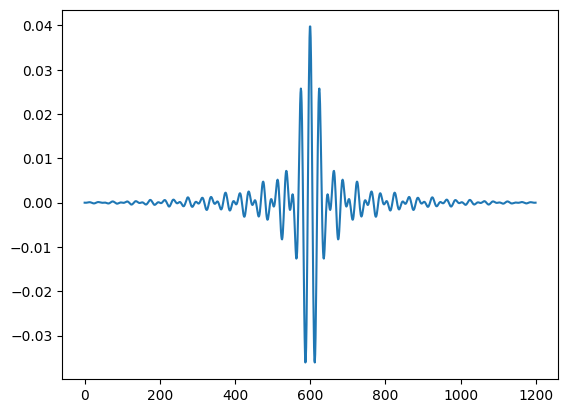

In [8]:
"""Ripple Filtering"""
h_filt = sci.signal.firwin(1200, [150,250], width=10, window='hamming', pass_zero='bandpass', scale=True, fs=fs)
plt.plot(h_filt)
pyramidal_ripfilt = sci.signal.filtfilt(h_filt,1,pyramidal_downsampled,axis=0)

In [9]:
fs

5000.0

In [10]:
""" Hilbert & Smooth """
hilbert_signal = sci.signal.hilbert(pyramidal_ripfilt )
pyramidal_envelope = np.abs(hilbert_signal)
pyramidal_inst_phase = np.unwrap(np.angle(hilbert_signal))
pyramidal_inst_frequency = (np.diff(hilbert_signal) /(2.0*np.pi) * fs)


gauss_width_ms = 4
sigma = gauss_width_ms/1000*fs
filter_width_sigmas = 8
pyramidal_smoothed  = sci.ndimage.gaussian_filter1d(pyramidal_envelope, sigma, axis=0, mode='reflect', truncate=filter_width_sigmas)

In [11]:
""" Z-score """
def z_with_params(x,mean,std):
    return (x-mean)/std

full_trace_std = np.std(pyramidal_smoothed)
full_trace_mean = np.mean(pyramidal_smoothed)
pyramidal_ripp_z = z_with_params(pyramidal_smoothed,full_trace_mean,full_trace_std)

In [12]:
print(pyramidal_ripp_z.shape)

(18192760,)


In [13]:
""" Find Ripps """
over_absolute_min_thresh = pyramidal_ripp_z>5
starts = np.where(np.diff(over_absolute_min_thresh,prepend=0)==1)[0]
stops = np.where(np.diff(over_absolute_min_thresh,prepend=0)==-1)[0]
print(len(starts),len(stops))

1187 1187


In [14]:
delta=stops-starts
duration = delta/fs
is_long_enough = duration > (15/1000)
good_starts = starts[is_long_enough]
good_stops = stops[is_long_enough]


inter_rip_interval = (good_starts[1:] - good_stops[:-1])/fs
interaval_ok = inter_rip_interval>.001
interaval_ok = np.pad(interaval_ok,[1,0])
interaval_ok[0]=True
good_starts=good_starts[interaval_ok]
good_stops=good_stops[interaval_ok]


print(len(good_starts))

676


In [ ]:
import pywt
widths=np.logspace(1,300,num=50,base=2)
cwtmatr, freqs = pywt.cwt(pyramidal_downsampled[:50000],widths,'morl',sampling_period=.0002)

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(6,2),dpi=300)

display_window_ms = [-150,300]
display_windo_indx = np.arange(display_window_ms[0]*fs/1000,display_window_ms[1]*fs/1000)
window_time_ms = display_windo_indx/fs*1000
random_start = np.random.choice(good_starts)
print(random_start)

chosen_indicies = random_start+display_windo_indx
chosen_rip = pyramidal_ripfilt[  chosen_indicies.astype(int)  ]
ax[0].plot(window_time_ms,   pyramidal_ripfilt[  chosen_indicies.astype(int)  ]  ,color='k',linewidth=.8)
ax[0].plot(window_time_ms,   pyramidal_smoothed[  chosen_indicies.astype(int)  ]  ,color='orange',linewidth=.8)
ax[0].axvline(0,color='k',linewidth=.5)
ax[0].plot(window_time_ms,   pyramidal_downsampled[  chosen_indicies.astype(int)  ] ,color='gray',linewidth=.2)
ax[1].plot(window_time_ms,   pyramidal_ripp_z[  chosen_indicies.astype(int)  ]  )
ax[1].set_ylim([-4,20])
ax[1].axvline(0,color='k',linewidth=.5)
ax[1].grid('on')
plt.tight_layout
plt.show()




In [ ]:
delta_len =  - len(pyramidal_ripfilt)
delta_len/fs




In [ ]:

mat_data = sci.io.loadmat(os.path.join(zl_dir, 'ZL04_46_LFP_unsubtracted01_17_ripfilt.mat'))
ripple_trace_MATLAB = mat_data['ZL04_46_LFP_unsubtracted01_17_ripfilt'].flatten()

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(4,2),dpi=300)
show_wind = np.arange(1*fs).astype(int)

ending_mat = len(ripple_trace_MATLAB)-show_wind-1
ending_py = len(pyramidal_ripfilt)-show_wind-1

ax[0].plot(time_trace[show_wind], ripple_trace_MATLAB[show_wind],linewidth=.2)
ax0r = ax[0].twinx()
ax0r.plot(time_trace[show_wind], pyramidal_ripfilt[show_wind],linewidth=.2,color='r')
# ax[0].set_title('Ripple Filtered Python vs Matlab\nAlligned to START')

ax[1].plot(time_trace[ending_py], ripple_trace_MATLAB[ending_mat],linewidth=.2)
ax1r = ax[1].twinx()
ax1r.plot(time_trace[ending_py], pyramidal_ripfilt[ending_py],linewidth=.2,color='r')
# ax[1].set_title('Trace Ripple Filtered Python vs Matlab\nAlligned to END')

plt.tight_layout()
plt.show()
# ax[0].set_title('Matlab DownSampled')
# ax[0].set_title('Python DownSampled')